In [1]:
import psutil
import platform
import time
import numpy as np
import cProfile
import pandas as pd
import matplotlib.pyplot as plt
from numba import cuda, njit

def print_device_specs():
    # Get CPU information
    print("CPU Info:")
    print(f"   Processor: {platform.processor()}")
    print(f"   Architecture: {platform.architecture()}")
    print(f"   Cores: {psutil.cpu_count(logical=False)} (Physical Cores)")
    print(f"   Threads: {psutil.cpu_count(logical=True)} (Logical Cores)\n")

    # Get memory information
    mem_info = psutil.virtual_memory()
    print("Memory Info:")
    print(f"   Total Memory: {round(mem_info.total / (1024 ** 3), 2)} GB")
    print(f"   Available Memory: {round(mem_info.available / (1024 ** 3), 2)} GB\n")

    # Get GPU information using psutil (Note: Limited GPU info, for more detailed GPU info, consider using additional libraries)
    try:
        import GPUtil
        gpus = GPUtil.getGPUs()
        if gpus:
            print("GPU Info:")
            for i, gpu in enumerate(gpus):
                print(f"   GPU {i + 1}:")
                print(f"      Name: {gpu.name}")
                print(f"      Memory Total: {round(gpu.memoryTotal / (1024), 2)} GB")
                print(f"      Memory Free: {round(gpu.memoryFree / (1024), 2)} GB")
                print(f"      Memory Used: {round(gpu.memoryUsed / (1024), 2)} GB")
                print()
        else:
            print("No GPU detected.")
    except ImportError:
        print("GPUtil library not installed. Install it using 'pip install gputil'.")

if __name__ == "__main__":
    print_device_specs()


CPU Info:
   Processor: Intel64 Family 6 Model 154 Stepping 3, GenuineIntel
   Architecture: ('64bit', 'WindowsPE')
   Cores: 14 (Physical Cores)
   Threads: 20 (Logical Cores)

Memory Info:
   Total Memory: 15.7 GB
   Available Memory: 10.11 GB

GPU Info:
   GPU 1:
      Name: NVIDIA GeForce RTX 3050 Ti Laptop GPU
      Memory Total: 4.0 GB
      Memory Free: 3.88 GB
      Memory Used: 0.0 GB



In [2]:

print_details = input("Do you want to print the details? (y/n): ")
print_details = print_details.lower()
#handle invalid input
while print_details != 'y' and print_details != 'n':
    print_details = input("Invalid input. Do you want to print the details? (y/n): ")
    print_details = print_details.lower()
@njit
def laplacian_2d_cpu(a):
    result = np.empty_like(a)
    for i in range(1, a.shape[0] - 1):
        for j in range(1, a.shape[1] - 1):
            result[i, j] = -4 * a[i, j] + a[i - 1, j] + a[i + 1, j] + a[i, j - 1] + a[i, j + 1]
    return result

@cuda.jit
def laplacian_2d_kernel(d_a):
    i, j = cuda.grid(2)
    
    if 1 <= i < d_a.shape[0] - 1 and 1 <= j < d_a.shape[1] - 1:
        laplacian_sum = -4 * d_a[i, j]
        laplacian_sum += d_a[i - 1, j] + d_a[i + 1, j] + d_a[i, j - 1] + d_a[i, j + 1]
        d_a[i, j] = laplacian_sum

def measure_memory_usage(obj):
    return obj.nbytes / (1024 ** 2)  # Convert bytes to megabytes

def run_benchmark(device, array_size):
    print(f"Running on {device} with array size {array_size} x {array_size}")
    a = np.random.rand(array_size, array_size)
    if device == 'cpu':
        # Run on CPU
        start_time_cpu = time.time()
        result_cpu = laplacian_2d_cpu(a)
        end_time_cpu = time.time()
        execution_time_cpu = (end_time_cpu - start_time_cpu) * 1000  # Convert to milliseconds
        memory_usage_cpu = measure_memory_usage(result_cpu)
        ops = 5 * (array_size - 2) ** 2  # 5 operations per element, excluding boundary
        throughput_cpu = ops / execution_time_cpu if execution_time_cpu > 1e-3 else 0  # OPS per second
        # Memory usage on CPU
        memory_usage_cpu = measure_memory_usage(result_cpu)
        interior_cpu = result_cpu[1:-1, 1:-1]
        del result_cpu
        del a
        if print_details == 'y':
            print(f"\nCPU Throughput: {throughput_cpu:.2f} OPS")
            print(f"CPU Execution Time: {execution_time_cpu:.5f} milliseconds")
            print(f"Memory Usage (CPU): {memory_usage_cpu:.2f} MB")
        
        return {'Device': device, 'Execution Time': execution_time_cpu, 'Memory Usage': memory_usage_cpu, 'Throughput': throughput_cpu}

    elif device == 'cuda':
        # Run on GPU
        d_a = cuda.to_device(a)
        threads_per_block = (16, 16)
        blocks_per_grid = ((a.shape[0] - 1) // threads_per_block[0] + 1, (a.shape[1] - 1) // threads_per_block[1] + 1)
        # Use CUDA events for accurate GPU timing
        start_event = cuda.event()
        end_event = cuda.event()
        start_event.record()
        laplacian_2d_kernel[blocks_per_grid, threads_per_block](d_a)
        end_event.record()
        # Synchronize and calculate elapsed time
        end_event.synchronize()
        execution_time_gpu = cuda.event_elapsed_time(start_event, end_event)# Convert to milliseconds
        memory_usage_gpu = measure_memory_usage(d_a.copy_to_host())
        ops = 5 * (array_size - 2) ** 2  # 5 operations per element, excluding boundary
        min_execution_time_threshold = 1e-3  # Minimum threshold for execution time (adjust as needed)
        throughput_gpu = ops / max(execution_time_gpu, min_execution_time_threshold)  # OPS per second
        memory_usage_gpu = measure_memory_usage(d_a.copy_to_host())
        interior_gpu = d_a.copy_to_host()[1:-1, 1:-1]
        del d_a
        del a
        if print_details == 'y':
            print(f"\nGPU Throughput: {throughput_gpu:.2f} OPS")
            print(f"GPU Execution Time: {execution_time_gpu:.5f} milliseconds")
            print(f"Memory Usage (GPU): {memory_usage_gpu:.2f} MB")
        return {'Device': device, 'Execution Time': execution_time_gpu, 'Memory Usage': memory_usage_gpu, 'Throughput': throughput_gpu}

    # Compare results between CPU and GPU
        
    # Ensure the shapes match for comparison
    min_shape = min(interior_cpu.shape[0], interior_gpu.shape[0])
    interior_cpu = interior_cpu[:min_shape, :min_shape]
    interior_gpu = interior_gpu[:min_shape, :min_shape]
    threshold = np.max(np.abs(interior_cpu - interior_gpu))
    match = np.allclose(interior_cpu, interior_gpu, atol=threshold)
    print(f"The interior elements match within the specified threshold of {threshold}. Match: {match} for {device}")


# Vary the array size for different runs
array_sizes = [2000, 4000, 8000,10000,12000,15000, 16000]

# List to store results
results_list = []

# Specify devices for comparison
devices = ['cpu', 'cuda']

for array_size in array_sizes:
    for device in devices:
        results = run_benchmark(device, array_size)
        results['Array Size'] = array_size
        results_list.append(results)
    # Calculate speedup factor based on all readings
    cpu_execution_times = results_list[-2]['Execution Time']
    gpu_execution_times = results_list[-1]['Execution Time']

    if gpu_execution_times > 0:
        speedup_factors = cpu_execution_times / gpu_execution_times
        print(f"The GPU speedup factor is approximately {speedup_factors:.2f} times.")
    else:
        print("The GPU execution times are very close to zero. Average speedup factor not defined.")
    print("-------------------------------------------")

# Create DataFrame from the list
results_df = pd.DataFrame(results_list)
print(results_df)

Running on cpu with array size 2000 x 2000
Running on cuda with array size 2000 x 2000
The GPU speedup factor is approximately 1.90 times.
-------------------------------------------
Running on cpu with array size 4000 x 4000
Running on cuda with array size 4000 x 4000
The GPU speedup factor is approximately 5.86 times.
-------------------------------------------
Running on cpu with array size 8000 x 8000
Running on cuda with array size 8000 x 8000
The GPU speedup factor is approximately 5.87 times.
-------------------------------------------
Running on cpu with array size 10000 x 10000
Running on cuda with array size 10000 x 10000
The GPU speedup factor is approximately 8.64 times.
-------------------------------------------
Running on cpu with array size 12000 x 12000
Running on cuda with array size 12000 x 12000
The GPU speedup factor is approximately 10.01 times.
-------------------------------------------
Running on cpu with array size 15000 x 15000
Running on cuda with array size

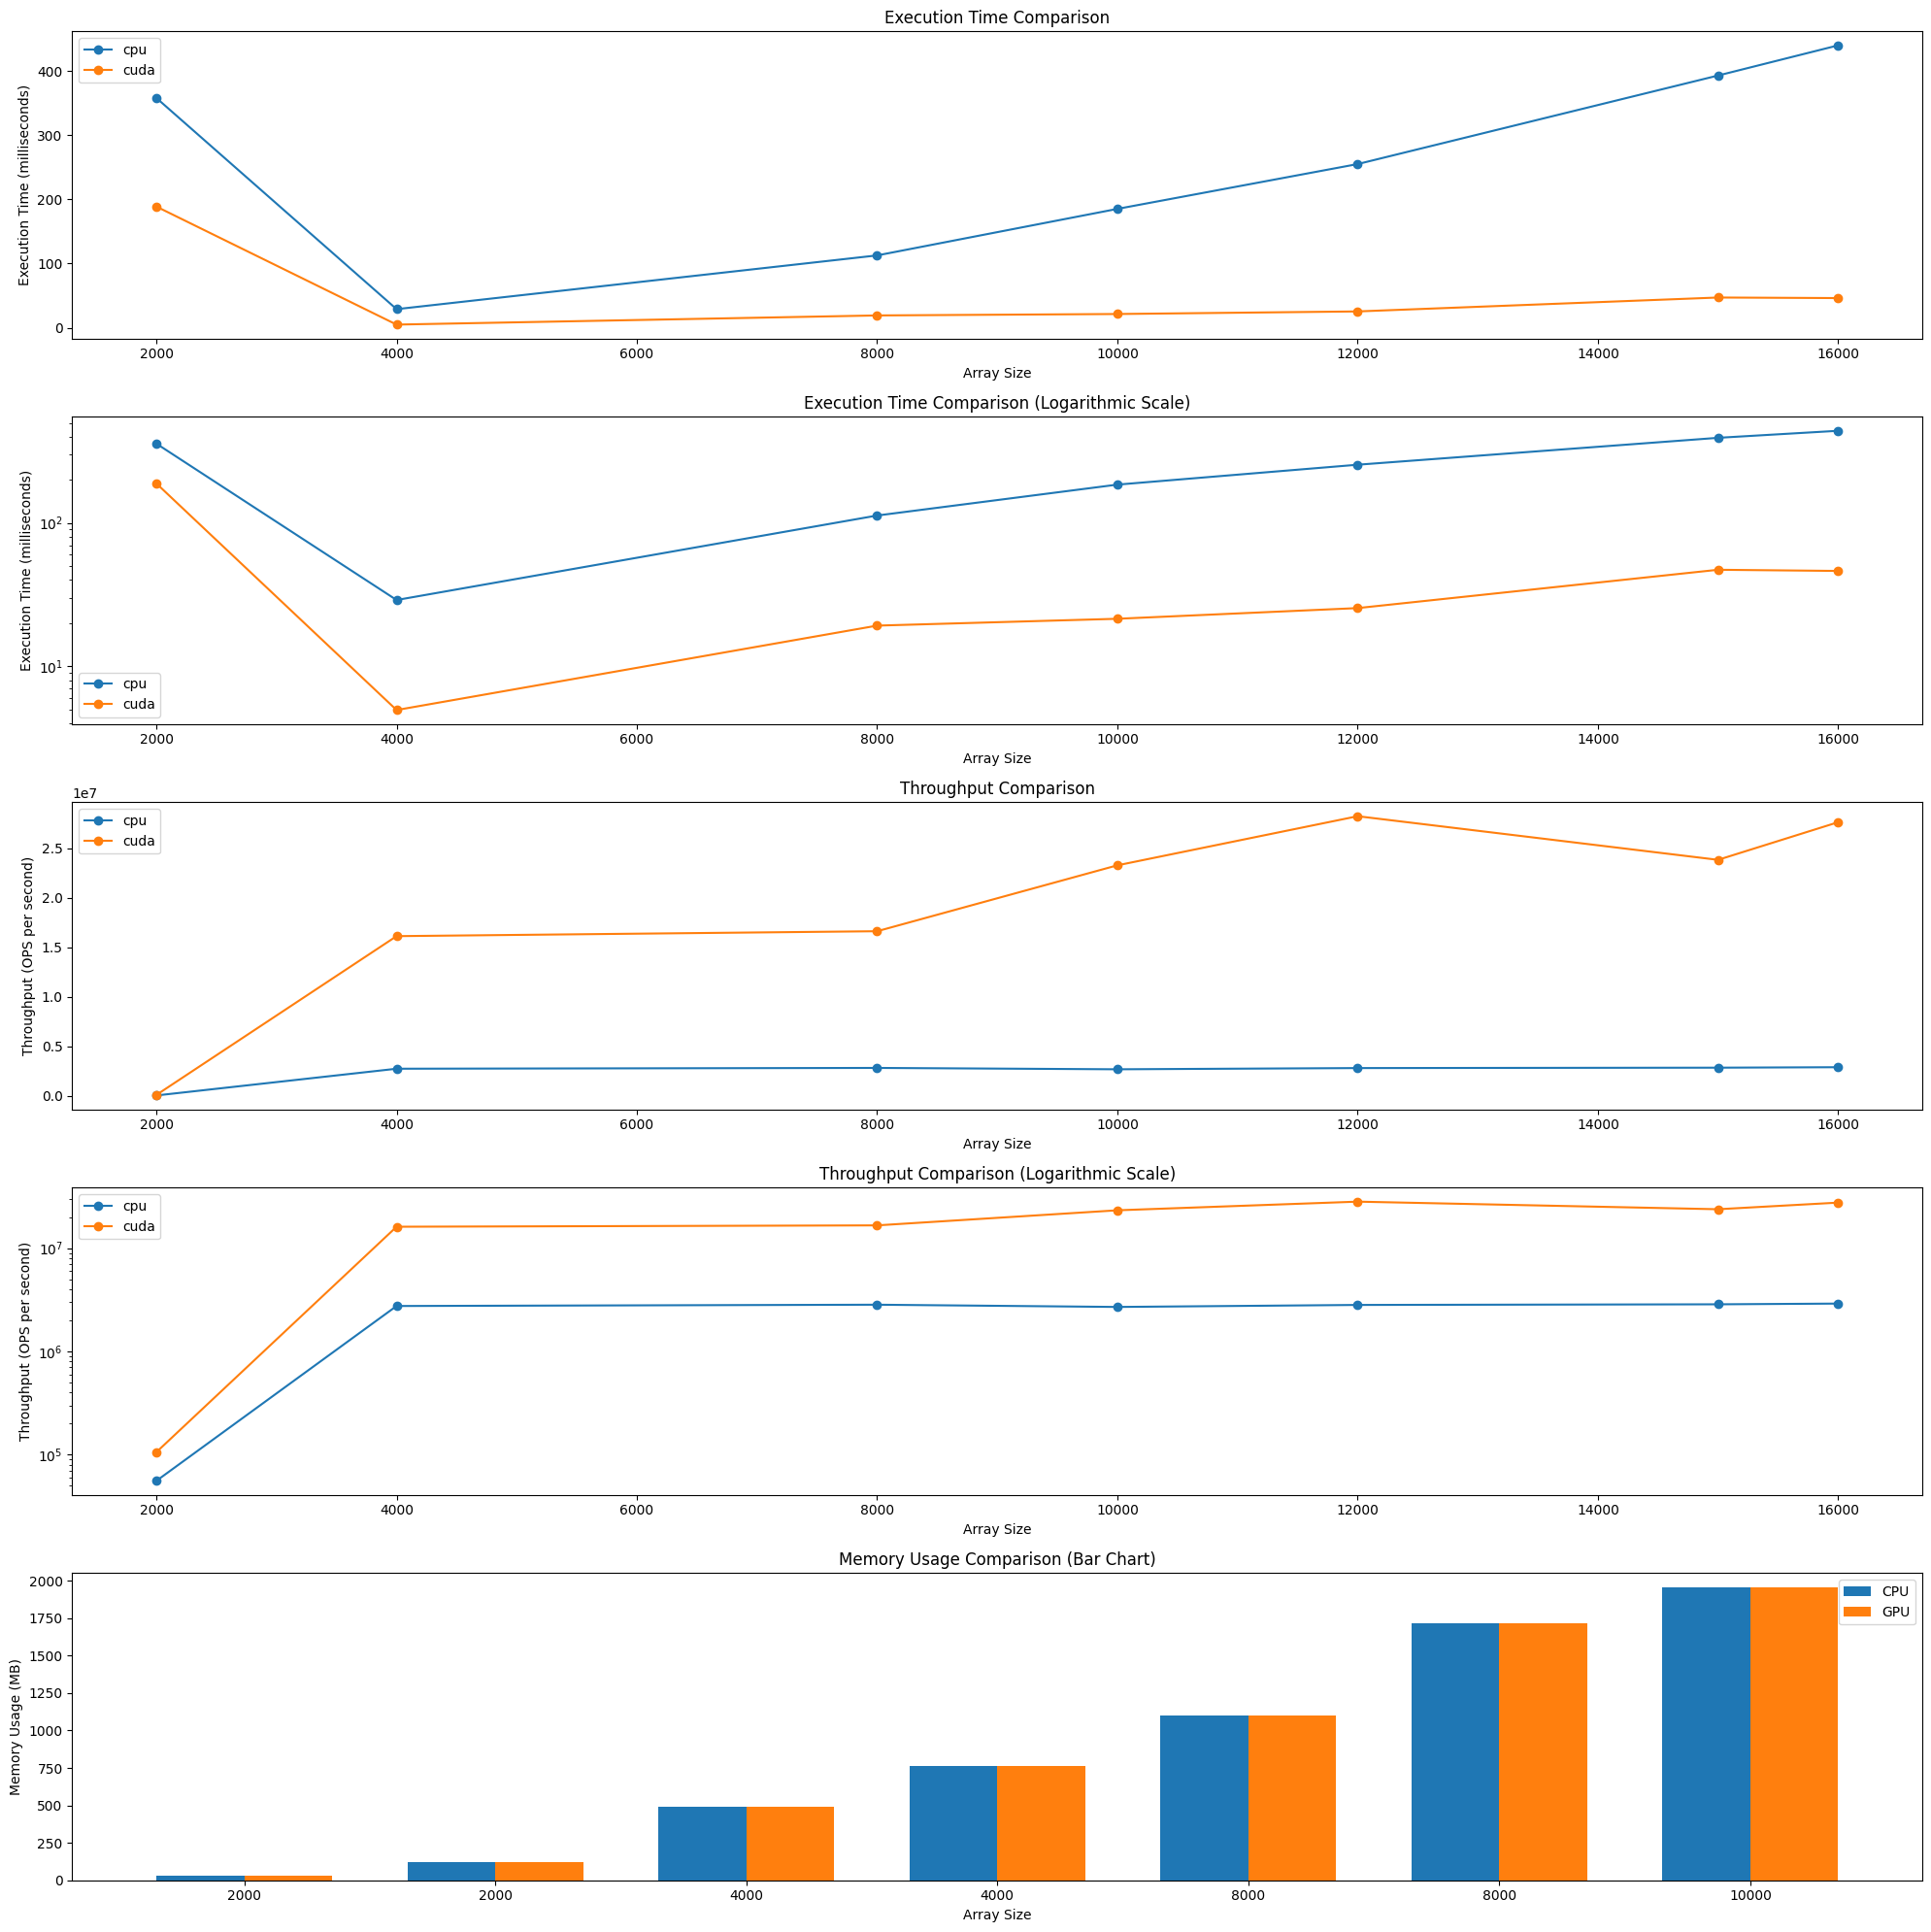

In [3]:
# Plotting
plt.figure(figsize=(20, 20))
# Line chart for Execution Time with logarithmic scale
plt.subplot(5, 1, 1)
for device in devices:
    device_results = results_df[results_df['Device'] == device]
    plt.plot(device_results['Array Size'], device_results['Execution Time'], marker='o', label=device)
plt.title('Execution Time Comparison')
plt.xlabel('Array Size')
plt.ylabel('Execution Time (milliseconds)')
plt.legend()

# Line chart for Execution Time with logarithmic scale
plt.subplot(5, 1, 2)
for device in devices:
    device_results = results_df[results_df['Device'] == device]
    plt.plot(device_results['Array Size'], device_results['Execution Time'], marker='o', label=device)
plt.yscale('log')
plt.title('Execution Time Comparison (Logarithmic Scale)')
plt.xlabel('Array Size')
plt.ylabel('Execution Time (milliseconds)')
plt.legend()

# Line chart for Throughput
plt.subplot(5, 1, 3)
for device in devices:
    device_results = results_df[results_df['Device'] == device]
    plt.plot(device_results['Array Size'], device_results['Throughput'], marker='o', label=device)
plt.title('Throughput Comparison')
plt.xlabel('Array Size')
plt.ylabel('Throughput (OPS per second)')
plt.legend()

# Line chart for Throughput
plt.subplot(5, 1, 4)
for device in devices:
    device_results = results_df[results_df['Device'] == device]
    plt.plot(device_results['Array Size'], device_results['Throughput'], marker='o', label=device)
plt.yscale('log')
plt.title('Throughput Comparison (Logarithmic Scale)')
plt.xlabel('Array Size')
plt.ylabel('Throughput (OPS per second)')
plt.legend()



# Bar chart for Memory Usage
plt.subplot(5, 1, 5)
bar_width = 0.35
index = np.arange(len(results_df))
memory_cpu = results_df['Memory Usage'][results_df['Device'] == 'cpu']
memory_gpu = results_df['Memory Usage'][results_df['Device'] == 'cuda']
min_len = min(len(memory_cpu), len(memory_gpu))
memory_cpu = memory_cpu[:min_len]
memory_gpu = memory_gpu[:min_len]
plt.bar(index[:min_len], memory_cpu, bar_width, label='CPU')
plt.bar(index[:min_len] + bar_width, memory_gpu, bar_width, label='GPU')
plt.title('Memory Usage Comparison (Bar Chart)')
plt.xlabel('Array Size')
plt.ylabel('Memory Usage (MB)')
plt.xticks(index[:min_len] + bar_width / 2, results_df['Array Size'][:min_len])
plt.legend()

plt.tight_layout()
plt.show()
